In [1]:
import scipy.io as sio 
import warnings
warnings.filterwarnings('ignore')

train = sio.loadmat('./train.mat')
test = sio.loadmat('./test.mat')
print(train.keys())
print(test.keys())


dict_keys(['y', '__header__', 'X', '__globals__', '__version__'])
dict_keys(['y', '__header__', 'X', '__globals__', '__version__'])


In [2]:
x_train = train['X'].swapaxes(0,3).swapaxes(2,3).swapaxes(1,2)
y_train = train['y']
x_test = test['X'].swapaxes(0,3).swapaxes(2,3).swapaxes(1,2)
y_test = test['y']

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (73257, 32, 32, 3)
y_train shape: (73257, 1)
73257 train samples
26032 test samples


In [3]:
y_train[y_train== 10] = 0
y_test[y_test== 10] = 0

In [4]:
# 使用一个通道训练模型，方便接PCA
x_train = x_train[:,:,:,0]
x_test = x_test[:,:,:,0]

img_rows = 32
img_cols = 32

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


x_train shape: (73257, 32, 32, 1)
x_test shape: (26032, 32, 32, 1)


In [5]:
x_train = x_train.reshape(73257,1024)
x_test = x_test.reshape(26032,1024)

In [6]:
from sklearn.decomposition import PCA

n_components = 256
x_train_pca = PCA(n_components = n_components).fit_transform(x_train)
x_test_pca = PCA(n_components = n_components).fit_transform(x_test)

print('x_train_pca.shape',x_train_pca.shape)
print('x_test_pca.shape',x_test_pca.shape)

x_train_pca.shape (73257, 256)
x_test_pca.shape (26032, 256)


In [7]:
x_train_pca = x_train_pca.reshape(x_train_pca.shape[0], 16, 16, 1)
x_test_pca = x_test_pca.reshape(x_test_pca.shape[0], 16, 16, 1)

print('x_train_pca shape:', x_train_pca.shape)
print('x_test_pca shape:', x_test_pca.shape)


x_train_pca shape: (73257, 16, 16, 1)
x_test_pca shape: (26032, 16, 16, 1)


In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import warnings
warnings.filterwarnings('ignore')

batch_size = 32
num_classes = 10
epochs = 20

Using TensorFlow backend.


In [9]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (73257, 10)
y_test shape: (26032, 10)


In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train_pca.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [11]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [12]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = LossHistory()

model.fit(x_train_pca, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test_pca, y_test),
          shuffle=True,
         callbacks=[history])

# Score trained model.
scores = model.evaluate(x_test_pca, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 24s 321us/step - loss: 2.3715 - acc: 0.1847 - val_loss: 2.2375 - val_acc: 0.2101
Epoch 2/20
73257/73257 [==============================] - 23s 316us/step - loss: 2.1543 - acc: 0.2277 - val_loss: 2.2614 - val_acc: 0.1959
Epoch 3/20
73257/73257 [==============================] - 23s 320us/step - loss: 2.0958 - acc: 0.2459 - val_loss: 2.2919 - val_acc: 0.1633
Epoch 4/20
73257/73257 [==============================] - 23s 310us/step - loss: 2.0385 - acc: 0.2742 - val_loss: 2.3325 - val_acc: 0.1740
Epoch 5/20
73257/73257 [==============================] - 23s 314us/step - loss: 1.9857 - acc: 0.2973 - val_loss: 2.3696 - val_acc: 0.1690
Epoch 6/20
73257/73257 [==============================] - 22s 301us/step - loss: 1.9355 - acc: 0.3136 - val_loss: 2.3952 - val_acc: 0.1662
Epoch 7/20
73257/73257 [==============================] - 21s 293us/step - loss: 1.8919 - acc: 0.3325 - val_loss: 2.

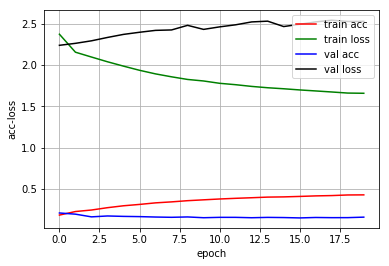

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

history.loss_plot('epoch')